In [2]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual 
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def t_real(tfinal, dt):
  return np.arange(0.1, tfinal, dt)

def temperature(T_c, t_real):
  # T[K]
  return T_c*np.ones(len(t_real))

# Modellierung der Entwicklung der Hydratationswärme

Dr.-Ing. Jithender J. Timothy &
Prof. Christoph Gehlen




Wie können wir die Höchsttemperatur in einem massiven Betonblock mit Zementtyp A und Zementgehalt B prognostizieren?

Antwort: Modellierung und Simulation 

**Beispielrechnung für CEM 1 42.5 N**



1.   Spezifikation der Zusammensetzung des Zements + additives in Gewichtsprozenten
2.   Angabe des Wasserzementwertes

In [1]:
c3s = 0.64
c2s = 0.15
c3a = 0.1
c4af = 0.08
so3 = 0.033
cao = 0.08
mgo = 0.06
blaine = 367
slag = 0.0
fa = 0
cao_fa = 0
wc = 0.44

**Hydratationswärme**

Die gesamte kumulative Wärme $Q(t_e)$ ist proportional zum Hydratationsgrad $\alpha$. $Q_{pot}$ ist die gesamte verfügbare Wärme.

$Q(t, T) = Q_{pot} \alpha(t, T)$

In der nachstehenden Tabelle ist der Gesamtbetrag der Hydratationswärme $[J/g]$ der einzelnen Bestandteile des Zements. 


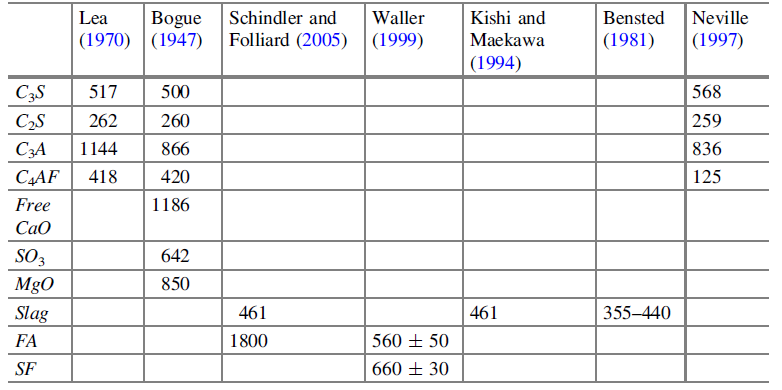

Die Gesamthydratationswärme des Zements kann aus dem gewichteten Durchschnitt der Hydratationswärme der einzelnen Bestandteile des Zements berechnet werden.

$Q_{pot} = \sum p_i Q^i_{pot}$.

$p_i$ ist der Gewichtsanteil der Komponente.

In [4]:
def Q_pot(c3a, c3s, so3, slag, fa, cao, cao_fa, mgo, c4af):
  term1 = 500*c3s + 260*c2s + 866*c3a + 420*c4af + 624*so3 + 1186*cao + 850*mgo
  term2 = 1800*fa*cao_fa + 461*slag
  return term1 + term2

In [5]:
Q_pot_parameter = Q_pot(c3a, c3s, so3, slag, fa, cao, cao_fa, mgo, c4af)
Q_pot_parameter

645.672

**Hydratationsgrad**


Die Wärmeentwicklung durch die Zementhydratation kann mit verschiedenen Ansätzen modelliert werden. Das 3-Parameter-Exponentialmodell für den Hydratationsgrad wird häufig für die Vorhersage der Temperaturentwicklung in Beton verwendet:

$\alpha(t)=\alpha_{max}\exp[-\left(\frac{\tau}{t}\right)^{\beta}]$

In [6]:
def hydration_degree(alpha_max = 1, beta = 1, tau=10, t_equivalent=1):
  return alpha_max*np.exp(-(tau/t_equivalent)**beta)

$\alpha_{max}$ ist die maximale Hydratationsgrad. 

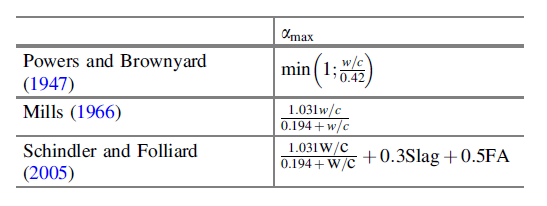

In [7]:
def max_hydration(wc, slag, FA):
  return 1.031*wc/(0.194 + wc) +0.3*slag + 0.5*FA

In [8]:
alpha_max_parameter = max_hydration(wc, 0, 0)
alpha_max_parameter

0.7155205047318611

$\tau$ und $\beta$ sind Modellparameter, deren Werte sich in Abhängigkeit von der Zementzusammensetzung ändern. 

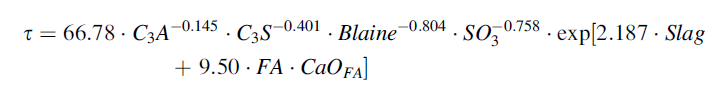

In [9]:
def tau_function(c3a, c3s, blaine, so3, slag, fa, cao_fa):
  return 66.78*c3a**(-0.145) * c3s**(-0.401) * blaine**(-0.804)*so3**(-0.758)*np.exp(2.187*slag + 9.50*fa*cao_fa)

In [10]:
tau_parameter = tau_function(c3a, c3s, blaine, so3, slag, fa, cao_fa)
tau_parameter

12.833442321765032

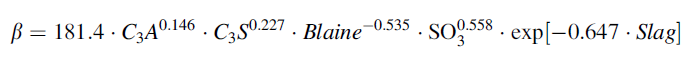

In [11]:
def beta_function(c3a, c3s, blaine, so3, slag, fa, cao_fa):
  return 181.4*c3a**(0.146) * c3s**(0.227) * blaine**(-0.535)*so3**(0.558)*np.exp(-0.647*slag)

In [12]:
beta_parameter = beta_function(c3a, c3s, blaine, so3, slag, fa, cao_fa)
beta_parameter

0.7410961735246708

wobei $C_3A$, $C_4AF$, $FA$, $Slag$ und $CaO_{FA}$ die 'weight fractions' in Bezug auf den Gesamtzementgehalt, Blaine ist spezifische Oberfläche des Zements $[m2/kg]$. 

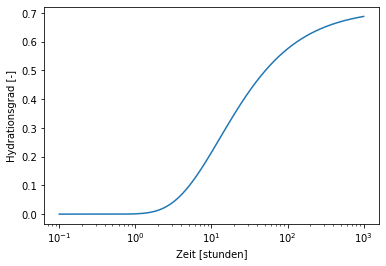

In [13]:
fig, ax = plt.subplots()
zeit = t_real(1000, 0.1)
ax.plot(zeit, [hydration_degree(alpha_max=alpha_max_parameter, beta=beta_parameter, tau=tau_parameter, t_equivalent=tx) for tx in zeit])
plt.xlabel('Zeit [stunden]')
plt.ylabel('Hydrationsgrad [-]')
ax.set_xscale('log')
plt.show;

**ACHTUNG ! CHEMISCHE REAKTIONEN SIND TEMPERATURABHÄNGIG! !**

**Konzept des äquivalenten Alters** - $t_e$

Die chemische Reaktion ist von der Temperatur abhängig. Bei höheren Temperaturen wird die Reaktion beschleunigt, während die Reaktion bei niedrigeren Temperaturen verlangsamt wird. Um das Modell für beliebige Aushärtungstemperaturen anwenden zu können, wird das Konzept eines äquivalenten Alters verwendet. Wir verwenden das Arrehenius-Gesetz zur Skalierung der Zeit. 

So können wir die Modellparameter für eine bestimmte Temperatur kalibrieren und dies auf andere Temperaturen anwenden, indem wir der 'Zeit-Parameter' verkleinern oder vergrößern.

Diese Skalierung ist eine Funktion der Aktivierungsenergie $E_a$. Die Energie, die zur Aktivierung der chemischen Reaktion benötigt wird. $T$ is die Betontemperatur and $T_{ref}$ ist die Referenztemperatur. $R$ ist die Gaskonstante.

$t_{e}(t,T)=\int_{0}^{t}exp(-\frac{E_{a}}{R}(\frac{1}{T}-\frac{1}{T_{ref}}))dt$


In [17]:
def equivalent_time(Ea=20000, T_c=293, T_ref=293, t=100, dt=1):
  temperature_evolution = temperature(T_c, t_real(t, dt))
  te = 0
  for T in temperature_evolution:
    te += np.exp((Ea/8.314)*(1/T_ref - 1/T))*dt
  return te

In der folgenden Grafik können wir mit den Parametern (T_c) spielen, um zu sehen, wie diese Skalierung funktioniert. Legen wir die Aktivierungsenergie zurzeit fest. 

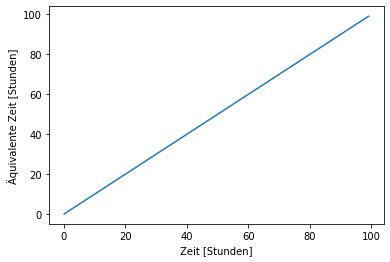

In [18]:
plt.plot(t_real(100, 1), [equivalent_time(Ea=20000, T_c=293, T_ref=293, t=tx, dt=1) for tx in t_real(100, 1)])
plt.xlabel('Zeit [Stunden]')
plt.ylabel('Äquivalente Zeit [Stunden]')
plt.show;

**Aktivierungsenergie** -  $E_a$

Die Aktivierungsenergie ($E_a$) einer Zementmischung kann anhand ihrer chemischen Zusammensetzung unter Verwendung der folgenden Beziehung berechnet werden. Diese Formel wird anhand von Daten aus isothermischen Kalorimetrieversuchen ermittelt. 



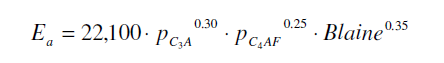

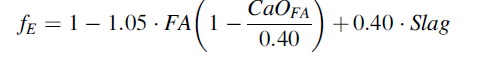

In [19]:
def activation_energy(c3a, c4af, blaine, fa, cao_fa, slag):
  # Ea [J/mol]
  f_E = 1 - 1.05*fa*(1 - cao_fa/0.4) + 0.4*slag
  return 22100*f_E*c3a**(0.3) * c4af**(0.25) * blaine**0.35
  #Formel aus Diss: Poole
  #https://repositories.lib.utexas.edu/bitstream/handle/2152/3470/pooled99569.pdf?sequence=2&isAllowed=y 

In [20]:
E_a_parameter = activation_energy(c3a, c4af, 367, fa, cao_fa, slag)
E_a_parameter

46536.94747139314

Nachdem wir nun den "Zeitparameter" neu definiert haben, erhalten wir den Hydratationsgrad als Funktion der Zeit und auch der Temperatur. 

$\alpha(t,T)=\alpha_{max}\exp[-\left(\frac{\tau}{t_{e} (t, T)}\right)^{\beta}]$

Berechnen wir nun die Entwicklung der Gesamthydratationswärme. 


In [21]:
def heat_of_hydration(Qpot = 500, Ea = 41800, T_c = 293, T_ref = 293,  alpha_max = 0.9, beta=0.9, tau=2, t_final=100, dt=0.5):
    
    plt.figure(2)
    time_vector = t_real(t_final, dt)

    Q = []

    for t_ime in time_vector:
      t_equi = equivalent_time(Ea, T_c, T_ref, t_ime, dt) + 0.01

      Q.append(Qpot*hydration_degree(alpha_max, beta, tau, t_equi))
    return Q

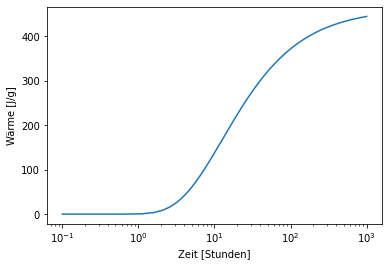

<Figure size 432x288 with 0 Axes>

In [22]:
fig, ax = plt.subplots();
zeit = t_real(1000, 0.5);
ax.plot(zeit, heat_of_hydration(Qpot=Q_pot_parameter, 
                                Ea=E_a_parameter, 
                                T_c=293, T_ref=293, 
                                alpha_max = alpha_max_parameter, 
                                beta = beta_parameter, 
                                tau=tau_parameter, 
                                t_final=1000, dt=0.5));
ax.set_xlabel('Zeit [Stunden]')
ax.set_ylabel('Wärme [J/g]')
ax.set_xscale('log');
plt.show;

Die Wärmeerzeugungsrate wird durch Ableitung der kumulierten Wärmeentwicklung über die Zeit berechnet.

In [23]:
def heat_rate(Qpot = 500, Ea = 41800, T_c = 293, T_ref = 293,  alpha_max = 0.9, beta=0.9, tau=2, t_final=100, dt=0.5):
    
    plt.figure(2)
    time_vector = t_real(t_final, dt)

    q = []

    for t_ime in time_vector:
      t_equi = equivalent_time(Ea, T_c, T_ref, t_ime, dt) + 0.01
      exponential_function = np.exp((Ea/8.314)*(1/T_ref - 1/T_c))
      consts = exponential_function*hydration_degree(alpha_max, beta, tau, t_equi)*(beta/t_equi)*(tau/t_equi)**beta
      q.append(Qpot*consts)
    return q

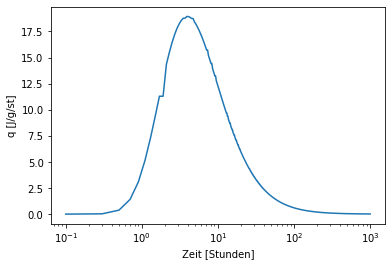

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots();
zeit = t_real(1000, 0.2);
ax.plot(zeit, heat_rate( Qpot=Q_pot_parameter, Ea=E_a_parameter, T_c=293, T_ref=293, alpha_max = alpha_max_parameter, beta = beta_parameter, tau=tau_parameter, t_final=1000, dt=0.2));
ax.set_xlabel('Zeit [Stunden]');
ax.set_ylabel('q [J/g/st]');
ax.set_xscale('log');
plt.show;

**Die maximale adiabatische Temperaturerhöhung**

Unter der Annahme, dass die durch die Hydratation entstehende Temperatur nicht abtransportiert wird, kann die zu erwartende Höchsttemperatur aus der maximal erzeugten Wärme berechnet werden. 

In [25]:
def adiabatic_temperature_rise(zementmenge, max_Q):
  return zementmenge*max_Q/(2350*1)

In [26]:
Zementmenge_im_beton = 400
temperature_rise = adiabatic_temperature_rise(400, 400)
temperature_rise

68.08510638297872